# Linear Data Dimensionality Reduction

### Setup

In [2]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir('..')

print("Current working directory: ", os.getcwd())
if not os.getcwd().endswith("Dimensionality-Reduction-Notebooks"):
    raise ValueError("Please change working directory to 'path/Dimensionality-Reduction-Notebooks' before proceeding")

Current working directory:  /Users/irellzane/MLprojects/Dimensionality-Reduction-Notebooks


In [3]:
!pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Dataset

#### Oval shaped dataset in 3D

In [5]:
np.random.seed(42)

m = 60
X = np.zeros((m, 3))
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5

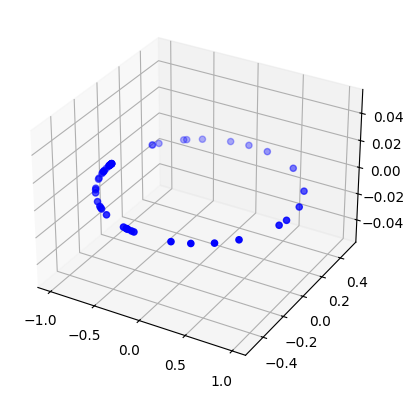

In [6]:

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')

plt.show()

#### Adding noise

In [7]:
X += 0.28 * np.random.randn(m, 3)

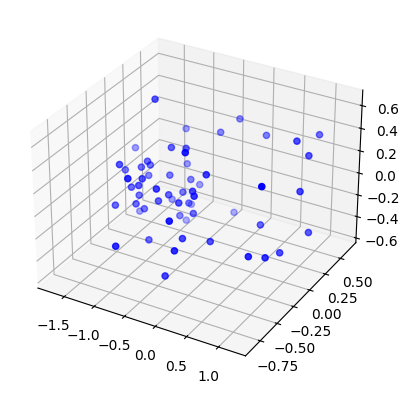

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')
plt.show()

#### Rotating dataset

In [9]:
from scipy.spatial.transform import Rotation

X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)

## PCA

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

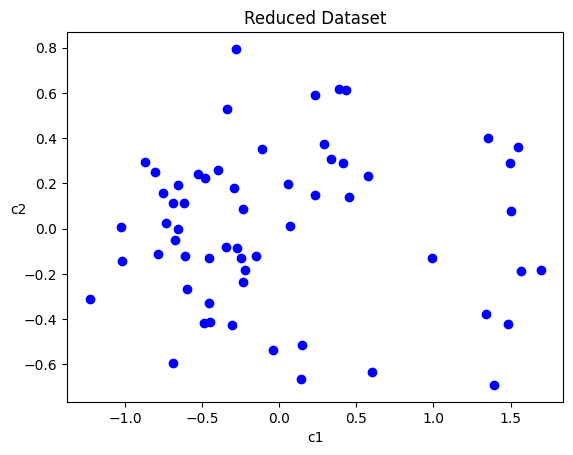

In [14]:
plt.plot(X2D[:, 0], X2D[:, 1], "bo")
plt.xlabel("c1")
plt.ylabel("c2", rotation=False)
plt.title("Reduced Dataset")
plt.show()

### Under the hood of PCA

In [12]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
principal_component_1 = Vt[0]
principal_component_2 = Vt[1]

In [15]:
W2 = Vt[:2].T
X2D = X_centered @ W2

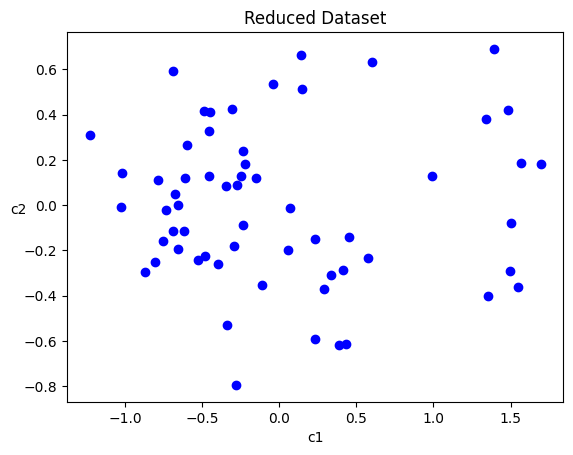

In [17]:
plt.plot(X2D[:, 0], X2D[:, 1], "bo")
plt.xlabel("c1")
plt.ylabel("c2", rotation=False)
plt.title("Reduced Dataset")
plt.show()

### Explained Variance Ratio

In [ ]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

## Reducing MNIST

#### Load MNIST

In [47]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", as_frame=False)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=1/7, random_state=42)

### Finding the number of dimensions param

In [49]:
variance_proportion = 0.95

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

d

154

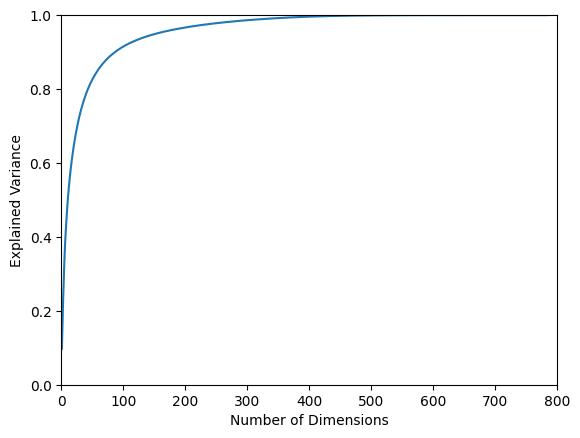

In [58]:
plt.plot(np.arange(len(cumsum)) + 1, cumsum)
plt.xlabel("Number of Dimensions")
plt.ylabel("Explained Variance")
plt.axis([0, 800, 0, 1])
plt.show()

### Using PCA class to automatically find dimensions

In [93]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [94]:
pca.n_components_

154

#### MNIST compressed

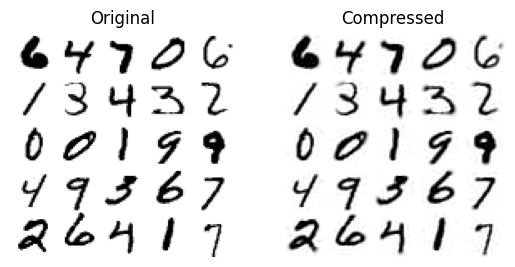

In [95]:
X_recovered = pca.inverse_transform(X_reduced)
Xs_mnist = [X_train, X_recovered]

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title("Original" if i == 0 else "Compressed")
    X_plot = Xs_mnist[i]
    for row in range(5):
        for col in range(5):
            plt.imshow(X_plot[row * 5 + col].reshape(28, 28), cmap="binary",
                        vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

### Tuning Number of Dimensions for classification

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)

rnd_search.fit(X_train[:1000], y_train[:1000])


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [69]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}

In [96]:
from sklearn.metrics import accuracy_score

tuned_model = rnd_search.best_estimator_
y_pred = tuned_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

## Randomized PCA

In [97]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

### Using memmap

In [ ]:
filename = "mmaps/mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode='write', shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [ ]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0]
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=60000, n_components=154)